# Vasicek and CIR models 

In this post, I discuss how to implement in Python the price of a Zero Coupon Bond with two very famous short term interest rate models, Vasicek and CIR

Under the Vasicek and CIR model, the short rate is respectively assumed to satisfy the following stochastic diﬀerential equations

$$ dr_t = k(\theta - r_0)dt + \sigma dW_t  $$

and

$$ dr_t = k(\theta - r_0)dt +\sigma \sqrt r_t dW_t $$ 

where $k$, $\theta$ and $\sigma $ are constants, and $r_0$ is
the current level of (short term) interest rates

### Vasicek model

The Vasicek model provides an analytical expression for the price of a zero coupon bond:

\begin{equation}
P(0,\tau) = A(\tau) e^{-B(\tau)r_0}
\end{equation}
<br>
\begin{equation}
A(\tau) = exp{\left[{{\left(\theta-\frac{\sigma^2}{2k^2}\right)}(B(\tau)-\tau) }-\frac{\sigma^2B^2(\tau)}{4k}\right]}
\end{equation}
<br>
\begin{equation}
B(\tau) = \frac{1-e^{-k\tau}}{k}
\end{equation}

### CIR model

The corresponding expression in the CIR is:

\begin{equation}
P(0,\tau) = A(\tau) e^{-B(\tau)r_0}
\end{equation}
<br>
\begin{equation}
A(\tau) = {\left(\frac{2he^{0.5(h+\tau)}}{2h+(h+k)(e^{h\tau}-1)}\right)}^{2k\theta/\sigma^2}
\end{equation}
<br>
\begin{equation}
B(\tau) = \frac{2(e^{h\tau}-1)}{2h+(h+k)(e^{h\tau}-1)}
\end{equation}
<br>
\begin{equation}
h = \sqrt{k^2+2\sigma^2}
\end{equation}

### zero and forward rate under continuous compounding

The zero rate for a term $\tau$ is equal to

\begin{equation}
s(\tau) = -\frac{log{P(0,\tau)}}{\tau}
\end{equation}

whereas the forward rate can be obtained with one of the following equivalent formulae

\begin{equation}
f(\tau) = s(\tau) + \tau \frac{ds(\tau)}{d\tau}
\end{equation}

\begin{equation}
f(\tau) = \frac{\frac{dP(0,\tau)}{d\tau}}{P(0,\tau)}
\end{equation}

\begin{equation}
f(\tau) = \frac{dlog(P(0,\tau))}{d\tau}
\end{equation}


### Price of a zero coupon bond with forward rates

The zero coupon bond price can be reconstructed using the forward rate as follows

$$ P(0, \tau) = \exp\left(-\int_0^{\tau}f(s)ds\right)$$

### Price of a zero coupon bond with simulating the short term interest rate

I started by writing the sde's for both vasicek and cir model, and so I can also use the expectation of the discount factors from the sample of Monte-Carlo paths, to calculate the zero coupon bond price.

$$P^{MC}(0,\tau) = E_0\left\{ e^{-\int_0^{\tau} r^{MC}(u) du} \right\}$$

where $r^{MC}(u)$ is the simulated path of the short term rate under the vasicek or cir model

### Python implementation

In python I implemented a $super$ class Bond, to deal with the calculation of the zero and forward rates, as well as calculating the monte carlo price. 

There are two $derived$ classes, $Vasicek$ and $CIR$,  which I use to $delegate$ the simulation of the short term rate $r_t$ with an $Euler$ scheme, and calculate the analytical price of a zcb under their respective sde's. They also contains some sanity checks methods, to ensure that the simulated paths are in line with the exptected short term rate  

### Load libraries

In [1]:
import numpy as np
import numpy.random as npr
import scipy.integrate as sciIntegr
from scipy import integrate

import matplotlib.pyplot as plt
%matplotlib inline

### a class to deal with payoffs

In [2]:
class Payoff(object):
    def __init__(self, K):
        self.K = K
    def f(self):
        pass
    
class ZCBOption(Payoff):
    def f(self, S):
        return np.maximum(P - K,0)

class ZCBValue(Payoff):
    def f(self, S):
        return S

### class Bond 

In [3]:
class Bond(object):
    def __init__(self, theta, kappa, sigma, r0=0.):
        '''
        r0    is the current level of rates
        kappa is the speed of convergence
        theta is the long term rate
        sigma is the volatility    
        '''
        self.theta = theta
        self.kappa = kappa
        self.sigma = sigma
        self.r0    = r0
        self.dt    = 0.001
    
    def B(self, t, T):
        pass
    
    def A(self, t, T): 
        pass
    
    def Exact_zcb(self, t, T):
        pass
    
    def Euler(self, M, I, T):
        pass
    
    def Yield(self, t, T, rate):
        return -1/(T-t)*self.A(t,T) + 1/(T-t)*self.B(t,T)*rate
    
    def SpotRate(self, t, T) :
        price = self.Exact_zcb(t, T)
        time  = T - t
        return (-np.log(price)/time)
    
    # Different ways to calculate the PV and cc Forward Rates 
    # 1    
    def ForwardRate1(self, time):
        up   = np.max(time + self.dt,0)
        down = np.max(time - self.dt,0)        

        r        = self.SpotRate(0, time)                        
        dr       = self.SpotRate(0, up) - self.SpotRate(0, down)
        dr_dt    = dr/(2*self.dt)         
        fwd_rate = r + time * dr_dt
        return fwd_rate
    # 2
    def ZCB_Forward_Integral1(self, t, T):    
        val = integrate.quad(self.ForwardRate1, t, T)[0]
        return np.exp(-val)
    
    def ForwardRate2(self, time):            
        up   = np.max(time + self.dt,0)
        down = np.max(time - self.dt,0)

        dP       = self.Exact_zcb(0, down) - self.Exact_zcb(0, up)     
        dP_dt    = dP/(2*self.dt)
        P        = self.Exact_zcb(0, time)
        fwd_rate = dP_dt/P
        return fwd_rate
    # 3
    def ZCB_Forward_Integral2(self, t, T):                    
        val = integrate.quad(self.ForwardRate2, t, T)[0]
        return np.exp(-val)

    def ForwardRate3(self, time):            
        up       = np.max(time + self.dt,0)
        down     = np.max(time - self.dt,0)

        dP       = np.log(self.Exact_zcb(0, down)) - np.log(self.Exact_zcb(0, up))     
        fwd_rate = dP/(2*self.dt)
        return fwd_rate 
    
    def ZCB_Forward_Integral3(self, t, T):                    
        val = integrate.quad(self.ForwardRate3, t, T)[0]
        return np.exp(-val)
    
    # Pricing with a sde
    def StochasticPrice(self, VectorRates, VectorTime):  
        # VectorRates is a two dimensional array:
        # with simulated rates in columns and timesteps rates in rows
        
        # we do not need VectorRates and VectorTime at the beginning of the simulation as it is r0        
        VectorRates = VectorRates[:-1,:]
        VectorTime  = VectorTime[:-1]
        
        No_Sim = VectorRates.shape[1]
         
        price  = np.zeros(No_Sim)
        for i in range(No_Sim):    
            Rates    = VectorRates[:,i].T
            price[i] = np.exp(-(sciIntegr.simps(Rates , VectorTime)))        
        
        RangeUp_Down   = np.sqrt(np.var(price))*1.96 / np.sqrt(No_Sim)
        Mean = np.mean(price)
                
        return Mean,  Mean + RangeUp_Down, Mean - RangeUp_Down
        
    def FutureZCB(self,M, I, T_0, T_M, Bond):  
        
        self.Euler(M, I, T_0)        
        bond = Bond    
        
        # we do not need VectorRates and VectorTime at the beginning of the simulation as it is r0        
        VectorRates = self.rates[:-1,:]
        VectorTime  = self.times[:-1]
        
        No_Sim = VectorRates.shape[1]
         
        price          = np.zeros(No_Sim)
        priceUntil_FO  = np.zeros(No_Sim)
        Payoff         = np.zeros(No_Sim)
        R0             = np.zeros(No_Sim)
        for i in range(No_Sim):    
            Rates      = VectorRates[:,i].T
            R0[i]      = Rates[-1]
            Yield      = self.Yield(T_0, T_M, Rates[-1])
            ZCBPrice   = np.exp(-Yield*(T_M-T_0)) 
            Payoff[i]  = bond.f(ZCBPrice)    
            price[i]   = np.exp(-(sciIntegr.simps(Rates , VectorTime)))*Payoff[i]      
            priceUntil_FO[i]  = np.exp(-(sciIntegr.simps(Rates , VectorTime)))
        
        RangeUp_Down   = np.sqrt(np.var(price))*1.96 / np.sqrt(No_Sim)
        Mean     = np.mean(price)
        MeanRate = np.mean(R0)
        FWDValue = np.mean(Payoff)
        MeanValueUntil_FO = np.mean(priceUntil_FO)
        return Mean,  Mean + RangeUp_Down, Mean - RangeUp_Down, FWDValue, MeanValueUntil_FO, MeanRate
    
    def ExpectedRate(self,t, T):
        pass
    
    def VarianceRate(self,t, T):
        pass

    def PlotEulerSim(self,Text, No_of_Sim = 10):        
        # We plot the first No_of_Sim simulated paths 
        
        plt.plot(self.times, self.rates[:, :No_of_Sim], lw=1.5)
        plt.xlabel('time - yrs')  
        plt.ylabel('rates level')
        plt.grid(True)
        plt.title(Text + ' - the first {}'.format(No_of_Sim) + " Simulated Paths");
        plt.show()

    def PlotEulerSim_Stats(self, Text):        
        # We plot and compare the average simulation +-2 sd of all time steps vs. what we expect from the model
        
        SimAverage  = np.mean(self.rates, 1)
        SimSD       = np.sqrt(np.var(self.rates, 1))
        AnalyAverage= np.asarray([self.ExpectedRate(0, i) for i in self.times])
        AnalySD     = np.asarray([np.sqrt(self.VarianceRate(0, i)) for i in self.times])
        
        plt.plot(self.times, SimAverage,           lw=1.5, label ='Sim Mean',linestyle=':')
        #plt.plot(self.times, SimAverage + 2*SimSD, lw=1.5, label ='Sim Mean + 2*SD',linestyle=':')
        #plt.plot(self.times, SimAverage - 2*SimSD, lw=1.5, label ='Sim Mean - 2*SD',linestyle=':')
        
        plt.plot(self.times, AnalyAverage,             lw=1.5, label ='Analy Mean',linestyle='-')
        #plt.plot(self.times, AnalyAverage + 2*AnalySD, lw=1.5, label ='Analy Mean + 2*SD',linestyle='-.')
        #plt.plot(self.times, AnalyAverage - 2*AnalySD, lw=1.5, label ='Analy Mean - 2*SD',linestyle='-.')
                
        plt.legend()
        
        plt.xlabel('time - yrs')  
        plt.ylabel('rates')
        plt.grid(True)        
        plt.title(Text);        
        plt.show()

### derived Vasicek class 

In [4]:
class Vasicek(Bond):
    def __init__(self, theta, kappa, sigma, r0=0.):
        Bond.__init__(self, theta, kappa, sigma, r0)
    
    def B(self, t, T):
        return (1 - np.exp(-self.kappa*(T-t))) / self.kappa
    
    def A(self, t, T): 
        return ((self.theta-(self.sigma**2)/(2*(self.kappa**2))) *(self.B(t, T)-(T-t)) \
                   -  (self.sigma**2)/(4*self.kappa)*(self.B(t, T)**2))
                
    def Exact_zcb(self, t, T):      
        B = self.B(t, T)
        A = self.A(t, T)
        return np.exp(A-self.r0*B)

    def Euler(self, M, I, tau):
        # I is the number of simulation
        # M is the number of time steps until maturity
        # tau is the maturity        
        dt = tau / float(M)

        M  = int(M)
        I  = int(I)
        xh = np.zeros((M + 1, I))
        self.rates = np.zeros_like(xh)
        self.times = np.linspace(0, tau, num = M + 1)
        
        xh[0]     = self.r0
        for t in range(1, M + 1):
            xh[t] = (xh[t - 1] + 
                  self.kappa * (self.theta - xh[t - 1]) * dt + \
                  self.sigma * np.sqrt(dt) * npr.standard_normal(I))
        self.rates = xh
        return 0
    
    def ExpectedRate(self,t, T):
        result = self.r0 * np.exp(-self.kappa*(T-t)) + self.theta*(1-np.exp(-self.kappa*(T-t))) 
        return result
    
    def VarianceRate(self,t, T):
        result = self.sigma**2/(self.kappa * 2) * (1- np.exp(- 2*self.kappa*(T-t)))
        return result

### derived CIR class 

In [5]:
class CIR(Bond):
    def __init__(self, theta, kappa, sigma, r0=0.):
        Bond.__init__(self, theta, kappa, sigma, r0)
    
    def B(self, t, T):
        tau = T-t # tau is the maturity
        h   = np.sqrt(self.kappa**2 + 2*self.sigma**2)
        den = (2*h +(h + self.kappa)* (np.exp(h*tau) - 1))        
        B   = 2*(np.exp(h*tau) - 1) / den
        return B
    
    def A(self, t, T):
        tau = T-t # tau is the maturity
        h   = np.sqrt(self.kappa**2 + 2*self.sigma**2)
        den = (2*h +(h + self.kappa)* (np.exp(h*tau) - 1))        
        
        A   = (2*h*(np.exp(0.5*(h + self.kappa)*tau)) / den)**(2*self.kappa*self.theta/(self.sigma**2))   
        return np.log(A)
                    
    def Exact_zcb(self, t, T):        
        B   = self.B(t,T)
        A   = self.A(t,T)
        return np.exp(A-self.r0*B)
        
    def ExpectedRate(self,t, T):
        tau = T-t
        result = self.r0 * np.exp(-self.kappa*tau) + self.theta*(1-np.exp(-self.kappa*tau)) 
        return result
    
    def VarianceRate(self,t, T):
        tau = T-t
        result = (self.sigma**2*self.theta)/(self.kappa * 2) * \
            ((1- np.exp(-self.kappa*tau))**2) + \
            self.sigma**2*self.r0/self.kappa*(np.exp(-self.kappa*tau) \
                                              - np.exp(-2*self.kappa*tau))
        return result
    
    def Euler(self, M, I, T):
        # I is the number of simulation
        # M is the number of time steps until maturity
        # T is the maturity        
        dt = T / float(M)

        M  = int(M)
        I  = int(I)
        xh = np.zeros((M + 1, I))
        self.rates = np.zeros_like(xh)
        self.times = np.linspace(0, T, num = M + 1)
        
        xh[0]     = self.r0
        for t in range(1, M + 1):
            xh[t] = (xh[t - 1] + 
                        kappa * (theta - xh[t - 1]) * dt +
                        sigma * np.sqrt(np.maximum(xh[t - 1], 0)) * np.sqrt(dt) \
                        * npr.standard_normal(I))
 
        self.rates = xh
        return 0   

### Vasicek

Let's practice with the analytical expression of the vasicek model

In [6]:
r0    = 0.05 # current level of rates
kappa = 3.0  # speed of convergence
theta = 0.02 # long term rate
sigma = 0.15 # vol    

tau   = 5    # maturity of the ZCB

### Using the analytic expression of a zero coupon bond, we have

In [7]:
vasicek = Vasicek(theta, kappa, sigma,r0)
print(vasicek.Exact_zcb(0, tau))

0.9008874042796438


In [8]:
print(vasicek.Exact_zcb(0,1))
print(vasicek.SpotRate(0, 1))
for i in [0.5,1,1.5,2]:
    print(vasicek.SpotRate(0, i))

0.9715756377800985
0.028836156499384966
0.03518625780860407
0.028836156499384966
0.0257531188319188
0.024049074065731868


### Which is the same as discouting the integral of the forward rate over the period 0, $\tau$

... a way to check that the forward rate can be obtained with three equivalent formulae (see introduction)

In [9]:
print(vasicek.ZCB_Forward_Integral1(0, tau))
print(vasicek.ZCB_Forward_Integral2(0, tau))
print(vasicek.ZCB_Forward_Integral3(0, tau))

0.9008874108448566
0.9008873902738813
0.9008873907663235


But we can also do the following

In [10]:
print(vasicek.Exact_zcb(0, tau -1)*vasicek.ZCB_Forward_Integral1(tau - 1, tau))
print(vasicek.Exact_zcb(0, tau -1)*vasicek.ZCB_Forward_Integral2(tau - 1, tau))
print(vasicek.Exact_zcb(0, tau -1)*vasicek.ZCB_Forward_Integral3(tau - 1, tau))
print(vasicek.Exact_zcb(0, tau))

0.900887404387224
0.9008874042785645
0.9008874042795567
0.9008874042796438


We the constant parameters above, the vasicek short term rate converges rapidly to its long term mean $\theta$

In [11]:
print(vasicek.ExpectedRate(0, 1)) 
print(vasicek.ExpectedRate(0, 2)) 
print(vasicek.ExpectedRate(0, 3)) 
print(theta) 

0.02149361205103592
0.020074362565299993
0.020003702294122603
0.02


and the following are equivalent!!

In [12]:
print(vasicek.Exact_zcb(0, 1))
print(vasicek.Exact_zcb(1, 2))

0.9715756377800985
0.9715756377800985


### Now, let's simulating the vasicek sde and price a zero coupon bond

In [13]:
# So we always use the same random numbers
npr.seed(1500)

I = 100000    # no. of simulations
M = tau * 252 # trading day per annum

In [14]:
vasicek.Euler(M, I, tau)
vals = vasicek.StochasticPrice(vasicek.rates, vasicek.times)

In [15]:
print("the MC price is        :", np.round(vals[0],4))
print("the MC price+1.96sd is :", np.round(vals[1],4))
print("the MC price-1.96sd is :", np.round(vals[2],4))
print("the Analytic price is  :" , np.round(vasicek.Exact_zcb(0,tau),4))

the MC price is        : 0.9008
the MC price+1.96sd is : 0.9014
the MC price-1.96sd is : 0.9002
the Analytic price is  : 0.9009


We the constant parameters above, the vasicek short term rate converges rapidly to its long term mean $\theta$

In [16]:
print(vasicek.ExpectedRate(0, 1)) 
print(vasicek.ExpectedRate(0, 2)) 
print(vasicek.ExpectedRate(0, 3)) 
print(theta) 

0.02149361205103592
0.020074362565299993
0.020003702294122603
0.02


We can now compare the average and standard deviation of the simulated paths (over time) against conditional expectation and standard deviation of the vasicek model, indicated in the grapf below as $Analy$.  

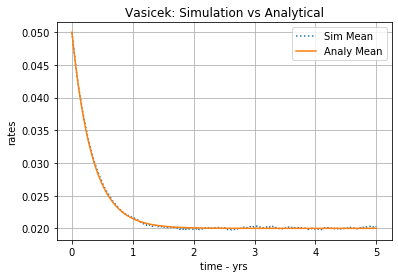

In [17]:
vasicek.PlotEulerSim_Stats("Vasicek: Simulation vs Analytical") 

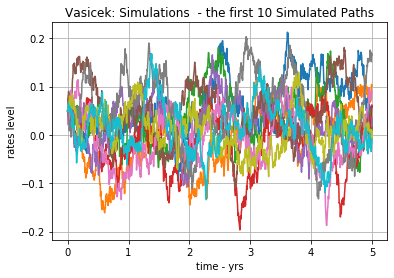

In [18]:
vasicek.PlotEulerSim("Vasicek: Simulations ")

We can also use the following

\begin{equation}
Y(t,T) = -\frac{A(t,T)}{T-t} + \frac{B(t,T)}{T-t}r_t
\end{equation}

together with simulating $dr_t$

For example, we can simulate $dr_t$ for one year, then calculate the $4yr$ yield $Y(1,5)$, and finally the value of a ZCB with a remaining maturity of 4 years

\begin{equation}
ZCB(1,5) = e^{-Y(1,5)4}
\end{equation}

The short term rate, $r_t$, in one year is expected to be 

In [19]:
vasicek.r0 = vasicek.ExpectedRate(0, 1) 
print ("Short term is expected to be at:", np.round(vasicek.r0,4))

Short term is expected to be at: 0.0215


So we expect the ZCB to have a value of

In [20]:
print(vasicek.Exact_zcb(0, 4))
newYield = vasicek.Yield(0, 4, vasicek.r0) 
# or as
print(np.exp(-newYield*(4)))
FwdPrice = np.exp(-newYield*(4))
# with a yield or spot rate with maturity of 4 years of
print(newYield)

0.9267023425939951
0.9267023425939951
0.019030715626121585


Before starting let's reset $r_0$

In [21]:
vasicek.r0 = 0.05

In [22]:
# So we always use the same random numbers
npr.seed(1500)

M   = tau * 252 # trading day per annum
T_M = 5
T_O = 1

BondValue = ZCBValue(0) # an instance of class ZCBValue, to model the payoff value at year 1    
vals = vasicek.FutureZCB(M,I, 1, 5, BondValue)

In [23]:
print( "------------------------------------------------------")
print("the MC price of a ZCB maturing in:",T_M, "years is:", np.round(vals[0],4))
print( "------------------------------------------------------")
print("the MC price +2sd is :", vals[1])
print("the MC price -2sd is :", vals[2])
print("the Price in",T_O,"year of a ZCB price maturing in",T_M,"years is", np.round(vals[3],4))

print("the MC price of a ZCB maturing in:",T_O, "year is       ", np.round(vals[4],4))
print( "------------------------------------------------------")
print("Matching the following :", np.round(vals[4]*vals[3],4))
print( "------------------------------------------------------")
print("The MC Expected short term rate in",T_O,"year is                        ", np.round(vals[5],4))
print("The Analytical Expected short term rate in",T_O,"year is expected to be ", np.round(vasicek.ExpectedRate(0, 1),4))


------------------------------------------------------
the MC price of a ZCB maturing in: 5 years is: 0.9008
------------------------------------------------------
the MC price +2sd is : 0.9010541658733731
the MC price -2sd is : 0.9004956901305854
the Price in 1 year of a ZCB price maturing in 5 years is 0.9268
the MC price of a ZCB maturing in: 1 year is        0.9715
------------------------------------------------------
Matching the following : 0.9004
------------------------------------------------------
The MC Expected short term rate in 1 year is                         0.0217
The Analytical Expected short term rate in 1 year is expected to be  0.0215


#### Let's check

In [24]:
# the price of a ZCB maturing in 1 year is very close
print(vasicek.Exact_zcb(0, 1))
# vs
np.round(vals[4],6)

0.9715756377800985


0.971515

In [25]:
# we previously calculated the Future Value in one year of a bond with a remaining maturity of 4 years
FwdPrice

0.9267023425939951

In [26]:
# vs a MC value of
print("the MC price of a ZCB maturing in:",T_O, "year is:", np.round(vals[3],5))

the MC price of a ZCB maturing in: 1 year is: 0.92684


In [27]:
# the ZCB maturing in 5 years is
print(vasicek.Exact_zcb(0, 5))
# vs the MC price of
np.round(vals[0],6)

0.9008874042796438


0.900775

Let's run some extra CHECKs, using the Forward Price.

Using the Forward Price (as calculated few steps above) we would expect now a ZCB with a 5 year maturity

In [28]:
FwdPrice*vasicek.Exact_zcb(0, 1)

0.9003614195380721

vs our MC value of

In [29]:
vals[0]

0.9007749280019792

They are very close!!

### But remeber there is a covariance effect with this check:
$$E[XY] = E[X]E[Y]+cov(X,Y)$$

$$P^{MC}(0,t;T) = E_0\left\{ G(t,T)e^{-\int_0^{t} r^{MC}(u) du} \right\}$$
$$= E_0[G(t,T)] * E_0\left\{e^{-\int_0^{t} r^{MC}(u) du} \right\} + Cov\left\{ G(t,T),e^{-\int_0^{t} r^{MC}(u) du} \right\}$$

where 
the check we implemented was $E_0[G(t,T)] * E_0\left\{e^{-\int_0^{t} r^{MC}(u) du} \right\} $

We can measure the covariance effect this way:

In [30]:
np.round(FwdPrice*vasicek.Exact_zcb(0, 1) - vals[0],5)

-0.00041

and note again the short term rate in one year as per MC vs the analytical expectation 

In [31]:
print("The MC Expected short term rate in",T_O,"year is                        ", np.round(vals[5],4))
print("The Analytical Expected short term rate in",T_O,"year is expected to be ", np.round(vasicek.ExpectedRate(0, 1),4))

The MC Expected short term rate in 1 year is                         0.0217
The Analytical Expected short term rate in 1 year is expected to be  0.0215


### CIR

Let's do the same now with the CIR mode and start by using the analytic expression of a zero coupon bond

In [32]:
cir = CIR(theta, kappa, sigma,r0)
print(cir.Exact_zcb(0, tau))

0.8959458667472219


we can simulate the short rate and calculate the zero coupon bond price

In [33]:
# So we always use the same random numbers
npr.seed(1500)

cir.Euler(M, I, tau)
valscir = cir.StochasticPrice(cir.rates, cir.times)

In [34]:
print("the price is:", valscir[0])
print("the price +2sd is :", valscir[1])
print("the price -2sd is :", valscir[2])

the price is: 0.8960219968791734
the price +2sd is : 0.8961095079164967
the price -2sd is : 0.8959344858418501


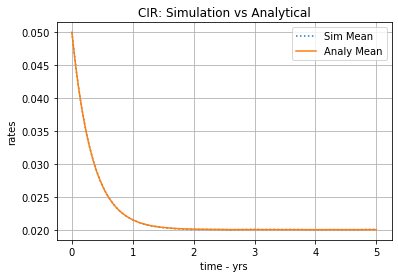

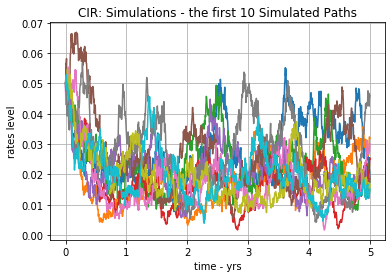

In [35]:
cir.PlotEulerSim_Stats("CIR: Simulation vs Analytical") 
cir.PlotEulerSim("CIR: Simulations" )

### Fitting the Vasicek Model

Is it possible to use the Vasicek model so that it can recover quoted Zero Coupon Bond Prices in the market?
Well, not really. The vasicek model is such a simple model. 
Below we try to fit our price data, but our results are disappointing!!

First we try to fit $k$ and $\theta$ keeping them the same across all maturity.

Following we also try to use a $ k(t) $ as a function of time, keeping $ \theta $ as originally used above

In [36]:
from scipy import optimize
class Fitting_Vasicek(Vasicek):
    def __init__(self, theta, kappa, sigma, r0, times, prices):
        Vasicek.__init__(self, theta, kappa, sigma, r0)
        self.times     = np.array(times)
        self.prices    = np.array(prices)
         
        self.kappatime       = np.zeros(self.prices.size)
        self.sim_pricesKappa = np.zeros(self.prices.size)
        self.t               = np.zeros(self.prices.size)
        
    def loss(self, x):
        self.theta = x[0]
        self.kappa = x[1]           
        self.sim_prices = list(map(self.Exact_zcb, self.t, self.times))            
        
        Tominimize      = 1000*(np.array(self.prices) - np.array(self.sim_prices))
        return 10000*np.sum(Tominimize**2)/len(self.times)
    
    def loss_kappa_t(self, x):
        # in this loss function, we assume that the Vasicek model has a kappa(t) 
        self.kappa                = x[0]           
                
        self.sim_pricesKappa[self.position] = self.Exact_zcb(0, self.timekappa)
        Tominimize                          = 1000*(self.sim_pricesKappa[self.position] - self.tomatch)
        return (Tominimize**2)
    
    def solve(self,x0 = np.random.rand(2)):
        self.opt_results = optimize.fmin(self.loss,x0=x0)
        self.theta       = self.opt_results[0]
        self.kappa       = self.opt_results[1]
        
        print("theta is :", np.round(self.theta,4), " ", "kappa is :", np.round(self.kappa,4))
    
    def solve_kappa_t(self, dati):        
        for i, (a, b) in enumerate(zip(dati.Time, dati.Prices)):
            x0               = np.random.rand(1)
            self.timekappa = a
            self.tomatch   = b
            self.position  = i
            x0 = np.random.rand(1)
            self.opt_results = optimize.fmin(self.loss_kappa_t, x0=x0)            
            self.kappatime[i]= self.opt_results[0]
        
    def printResult(self):
        # Create a zipped list of tuples from above lists
        zippedList =  list(zip(self.times, self.prices, self.sim_prices))
        df = pd.DataFrame(zippedList,columns=['Times','ImputPrices','SolutionPrices'])
        return df
    
    # alternative
    def printResult_2(self):
        report = pd.DataFrame(
        {'Times': self.times,
         'ImputPrices': self.prices,
         'SolPrices': self.sim_prices
        })
        return report

    def printResult_kappa(self):
        # Create a zipped list of tuples from above lists
        zippedList =  list(zip(self.times, self.prices, self.sim_prices, self.sim_pricesKappa, self.kappatime ))
        self.df = pd.DataFrame(zippedList,columns=['Times','ImputPrices','SolutionPrices', 'SolPricesKappa', 'Kappas'])
        pd.options.display.float_format = '{:.4f}'.format
        return self.df

In [37]:
import pandas as pd 
zeros = pd.read_csv("zeros.csv") 
print(zeros)
#print(zeros["Time"])

   Time     Zeros    Prices
0   0.5  0.018429  0.990828
1   1.0  0.020252  0.979951
2   1.5  0.021557  0.968182
3   2.0  0.022595  0.955815
4   2.5  0.023518  0.942899
5   3.0  0.024347  0.929564
6   3.5  0.025072  0.915987
7   4.0  0.025716  0.902250
8   4.5  0.026304  0.888370
9   5.0  0.026863  0.874313


In [38]:
r0    = 0.05 # current level of rates
kappa = 0.0  # speed of convergence
theta = 0.02 # long term rate
sigma = 0.021 # vol    
tau   = 5    # maturity of the ZCB

fitVasicek = Fitting_Vasicek(theta, kappa, sigma,r0,zeros["Time"], zeros["Prices"])
fitVasicek.solve()
print(fitVasicek.printResult())

theta is : 0.0254   kappa is : 22815867647.1957
   Times  ImputPrices  SolutionPrices
0    0.5     0.990828        0.987379
1    1.0     0.979951        0.974917
2    1.5     0.968182        0.962613
3    2.0     0.955815        0.950463
4    2.5     0.942899        0.938467
5    3.0     0.929564        0.926623
6    3.5     0.915987        0.914928
7    4.0     0.902250        0.903380
8    4.5     0.888370        0.891979
9    5.0     0.874313        0.880721


In [39]:
fitVasicek.theta = 0.02 # long term rate

In [40]:
fitVasicek.solve_kappa_t(zeros)
print(fitVasicek.printResult_kappa())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 42
Optimization terminated successful

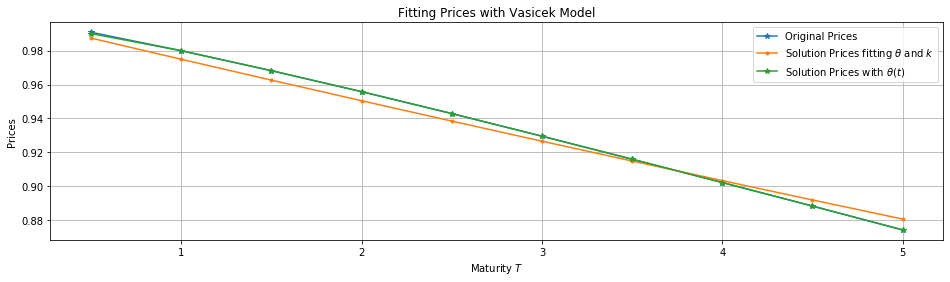

In [41]:
plt.figure(figsize=(16,4))

plt.plot(fitVasicek.df.Times, fitVasicek.df.ImputPrices, marker='*',    label = "Original Prices")
plt.plot(fitVasicek.df.Times, fitVasicek.df.SolutionPrices, marker='.', label = r"Solution Prices fitting $\theta$ and $k$")
plt.plot(fitVasicek.df.Times, fitVasicek.df.SolPricesKappa, marker='*', label = r"Solution Prices with $\theta(t)$")
plt.xlabel(r'Maturity $T$ ')
plt.title(r'Fitting Prices with Vasicek Model')
plt.grid(True)
plt.legend()
plt.ylabel('Prices')

plt.show()
